# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

In [2]:
cols = [
    "fLength",
    "fWidth",
    "fSize",
    "fConc",
    "fConc1",
    "fAsym",
    "fM3Long",
    "fM3Trans",
    "fAlpha",
    "fDist",
    "class",
]
df = pd.read_csv("magic04.data", names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [3]:
df["class"].unique()

array(['g', 'h'], dtype=object)

# Encoding Features

In [4]:
df["class"] = (df["class"] == "g").astype(int)

In [5]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


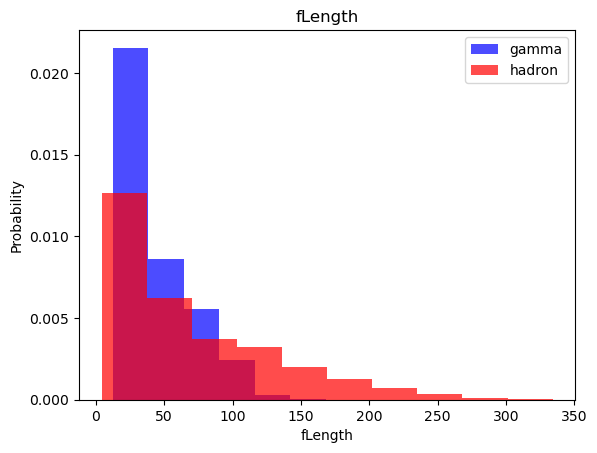

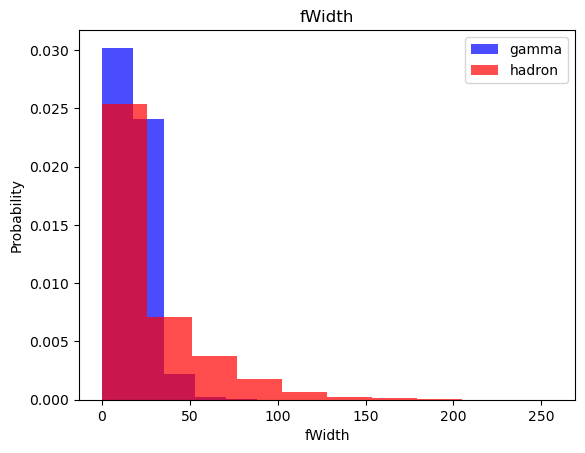

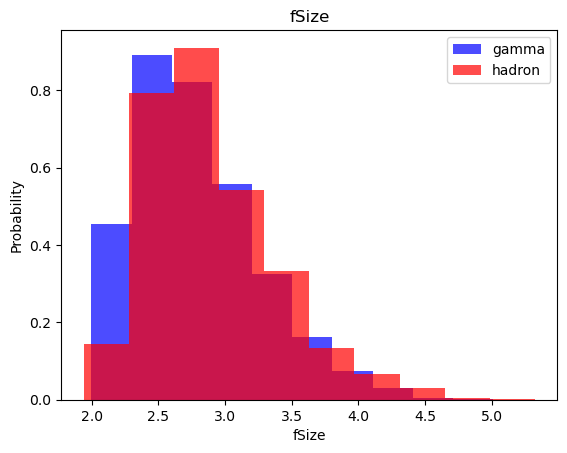

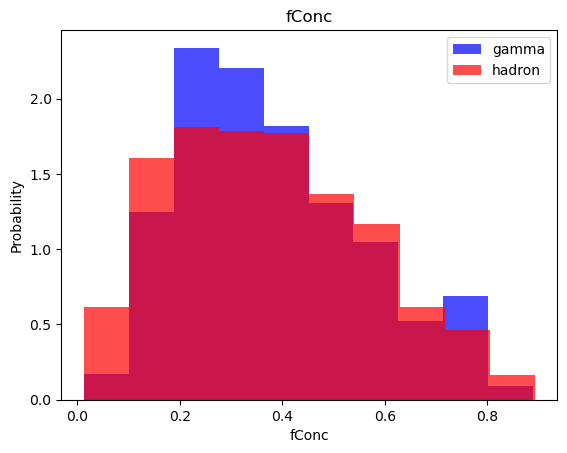

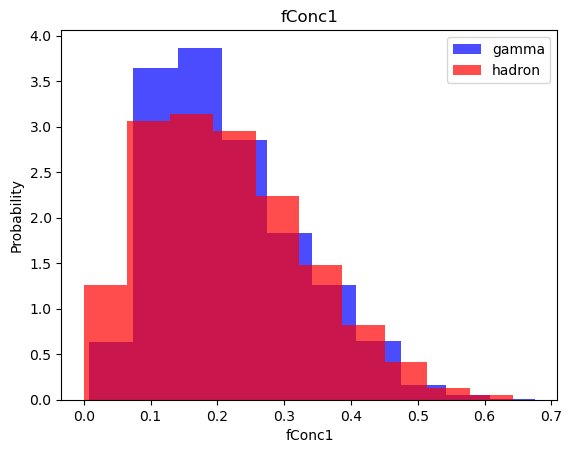

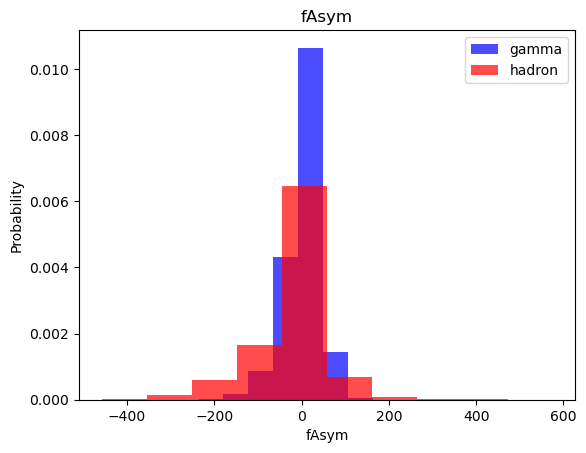

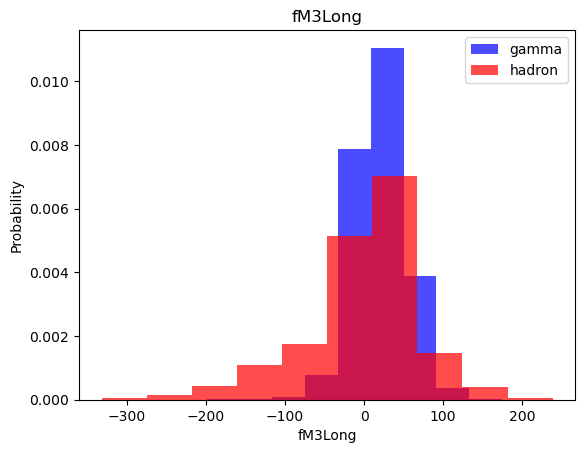

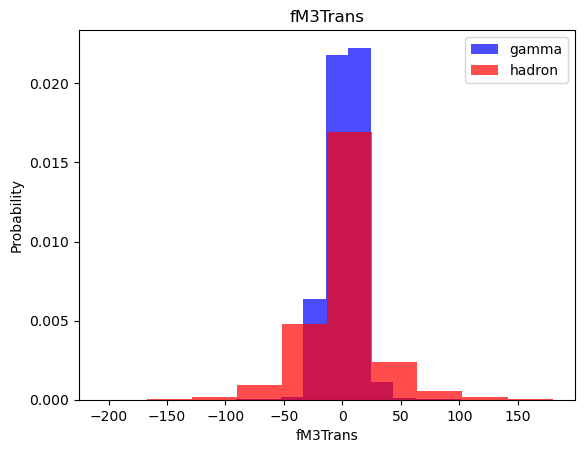

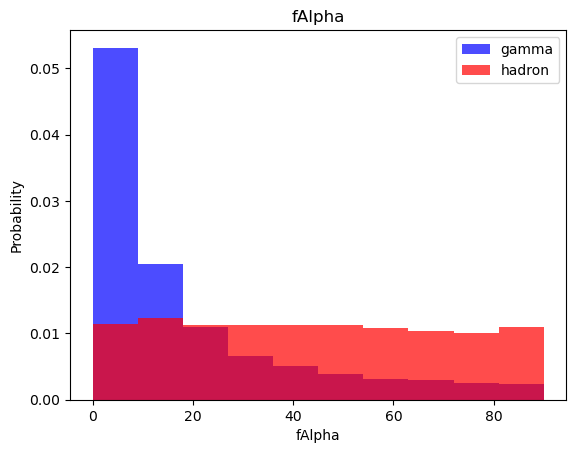

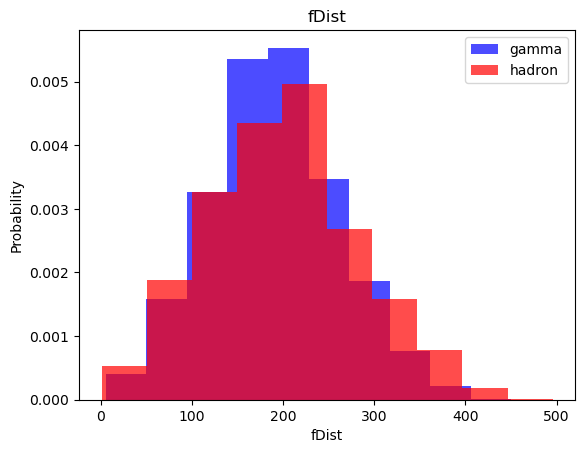

In [6]:
for label in df.columns[:-1]:
    plt.hist(
        df[df["class"] == 1][label],
        color="blue",
        label="gamma",
        alpha=0.7,
        density=True,
    )
    plt.hist(
        df[df["class"] == 0][label],
        color="red",
        label="hadron",
        alpha=0.7,
        density=True,
    )
    plt.title(label)
    plt.ylabel("Probability")
    plt.xlabel(label)
    plt.legend()
    plt.show()

# Train, Validation, Test datasets

In [7]:
# frac = 1 entire DataFrame will be sampled, and since it's being sampled with replacement (frac=1), this effectively shuffles the rows randomly.
train, valid, test = np.split(
    df.sample(frac=1), [int(0.6 * len(df)), int(0.8 * len(df))]
)

e:\Courses\Machine-Learning-for-Everybody\.conda\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)
    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data,X, y

# Resampling the data to Match be equal

In [9]:
print(len(train[train["class"] == 1]))
print(len(train[train["class"] == 0]))

train, X_train, y_train = scale_dataset(train, oversample=True)
# print("Train Set")
# print(sum(y_train == 1))
# print(sum(y_train == 0))

valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

7397
4015


# Build Neural Network

## Import Tensorflow

In [10]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

## Define Callback

In [11]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

## Plot Acc. & Loss

In [12]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Binary crossentropy")
    ax1.grid(True)

    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.grid(True)

    plt.show()

## Training Method

In [13]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
    nn_model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(num_nodes, activation="relu", input_shape=(10,)),
            tf.keras.layers.Dropout(dropout_prob),
            tf.keras.layers.Dense(num_nodes, activation="relu"),
            tf.keras.layers.Dropout(dropout_prob),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    nn_model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    history = nn_model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stopping]
    )

    return nn_model, history

## Looping with Different Variables

16 nodes, dropout 0, lr 0.01, batch size 32


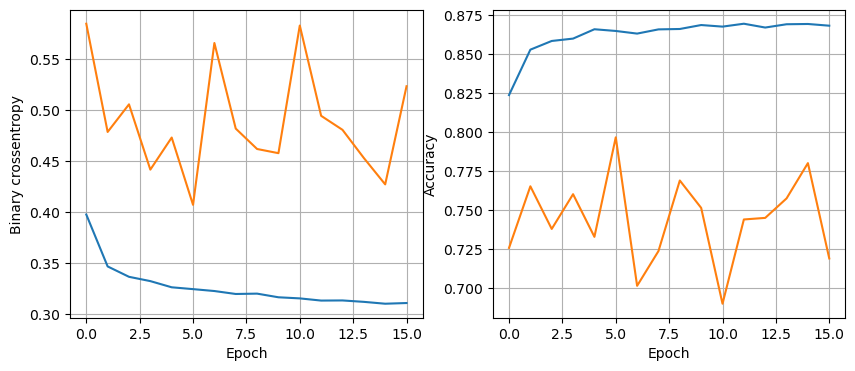



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3502 - accuracy: 0.8565
16 nodes, dropout 0, lr 0.01, batch size 64


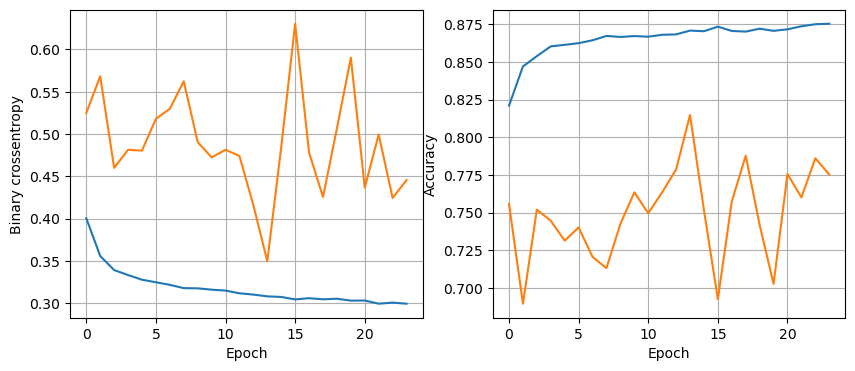



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3532 - accuracy: 0.8483
16 nodes, dropout 0, lr 0.01, batch size 128


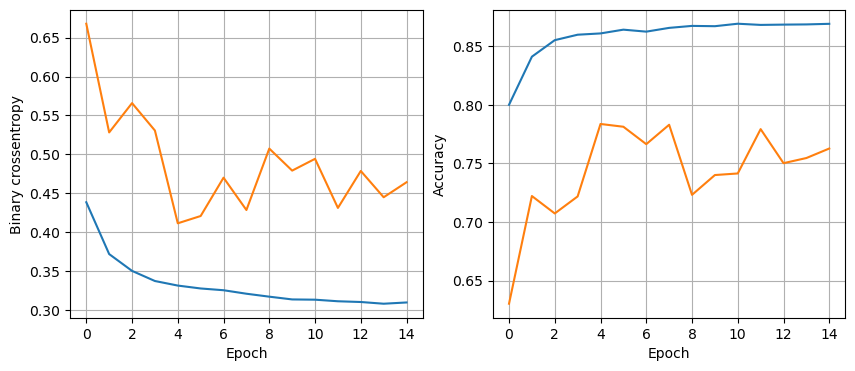



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3472 - accuracy: 0.8515
16 nodes, dropout 0, lr 0.005, batch size 32


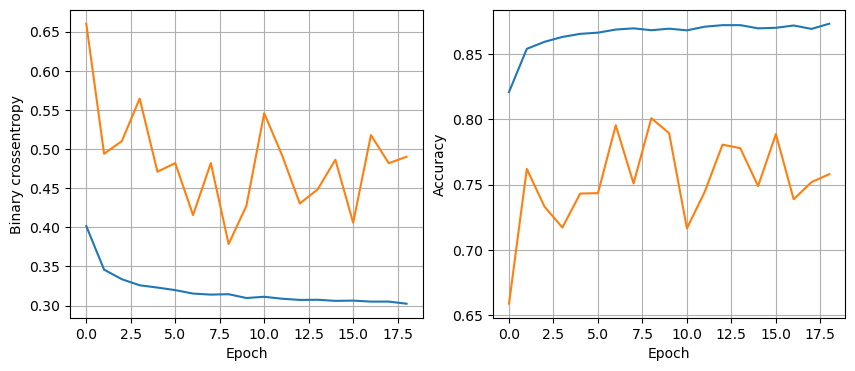



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3400 - accuracy: 0.8583
16 nodes, dropout 0, lr 0.005, batch size 64


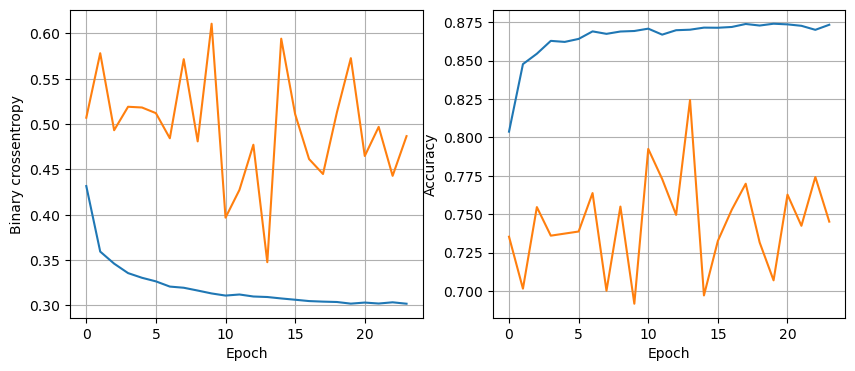



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3564 - accuracy: 0.8502
16 nodes, dropout 0, lr 0.005, batch size 128


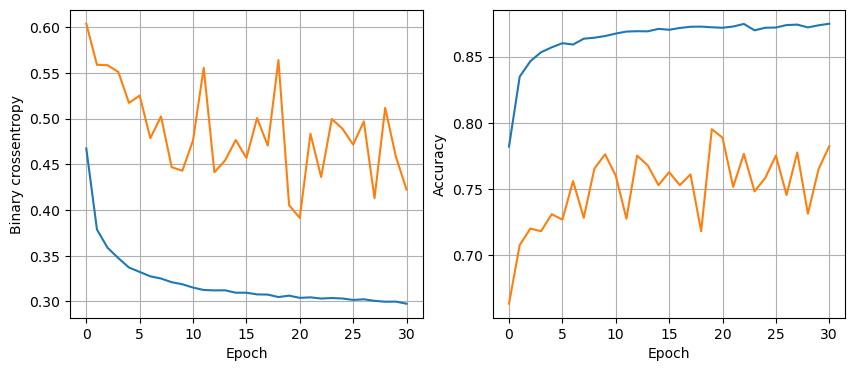



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3375 - accuracy: 0.8625
16 nodes, dropout 0, lr 0.001, batch size 32


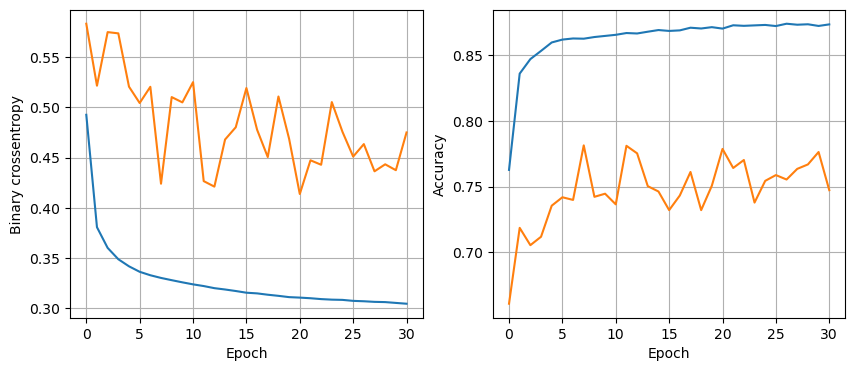



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3361 - accuracy: 0.8638
16 nodes, dropout 0, lr 0.001, batch size 64


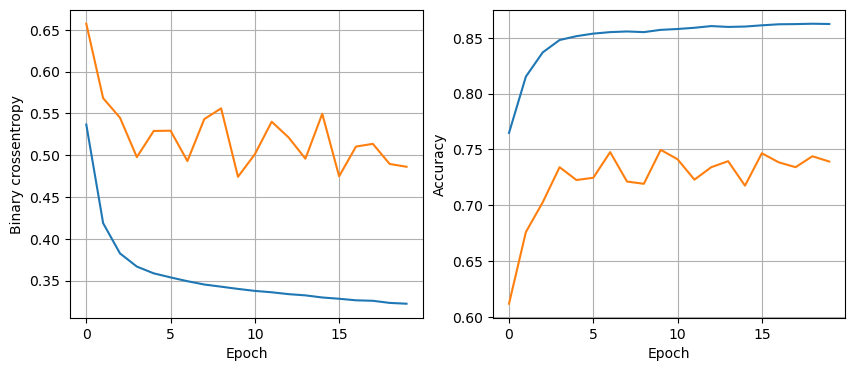



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3539 - accuracy: 0.8523
16 nodes, dropout 0, lr 0.001, batch size 128


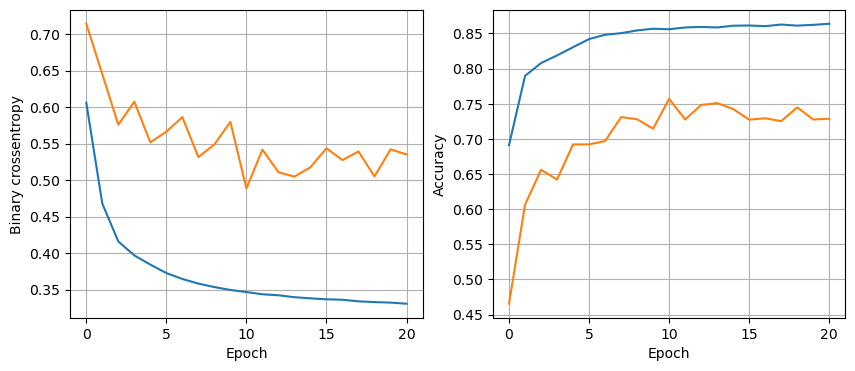



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3603 - accuracy: 0.8512
16 nodes, dropout 0.2, lr 0.01, batch size 32


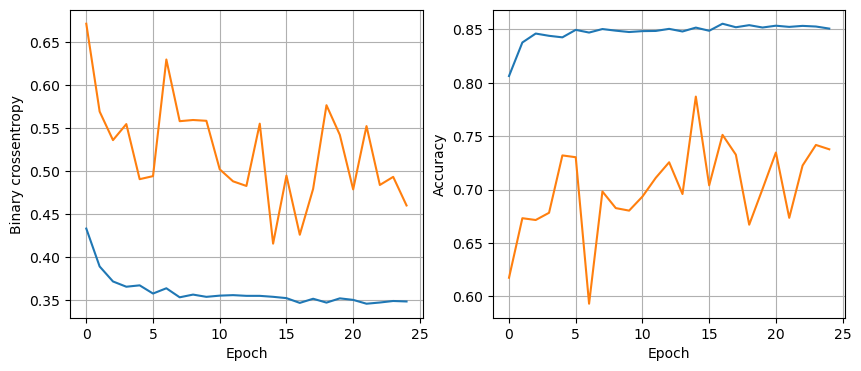



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3454 - accuracy: 0.8554
16 nodes, dropout 0.2, lr 0.01, batch size 64


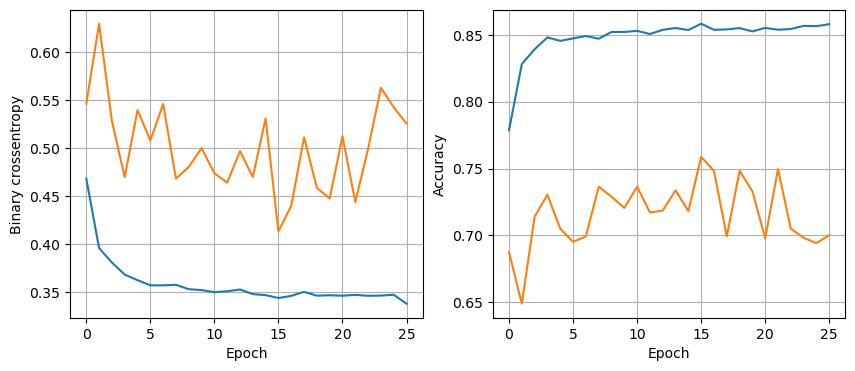



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3384 - accuracy: 0.8683
16 nodes, dropout 0.2, lr 0.01, batch size 128


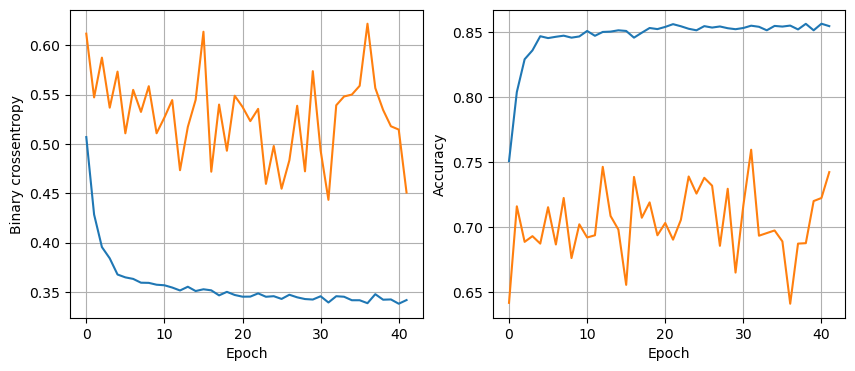



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3265 - accuracy: 0.8678
16 nodes, dropout 0.2, lr 0.005, batch size 32


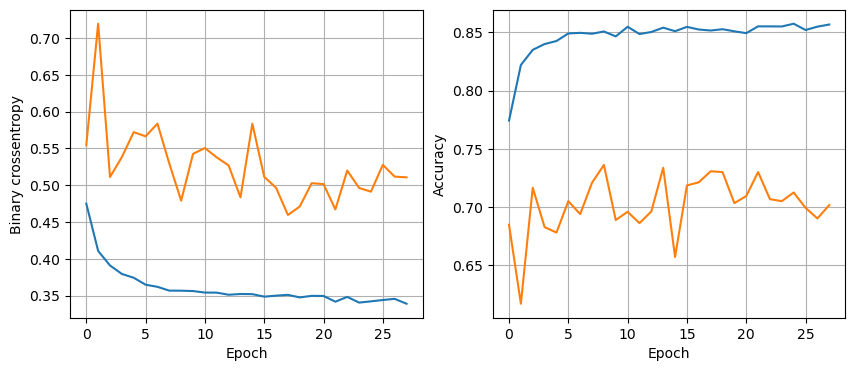



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3313 - accuracy: 0.8651
16 nodes, dropout 0.2, lr 0.005, batch size 64


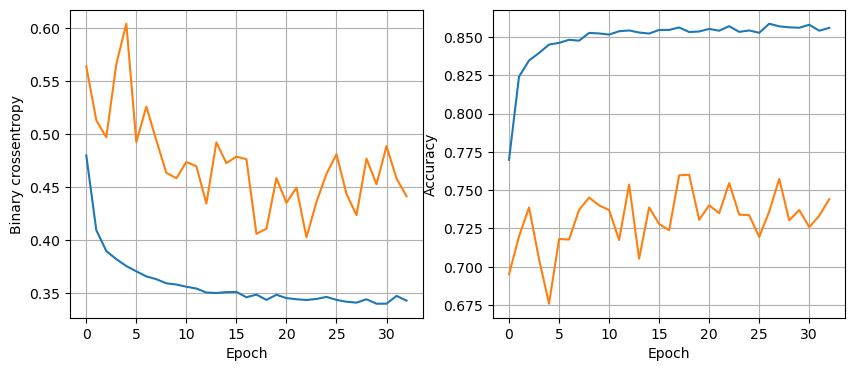



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3449 - accuracy: 0.8604
16 nodes, dropout 0.2, lr 0.005, batch size 128


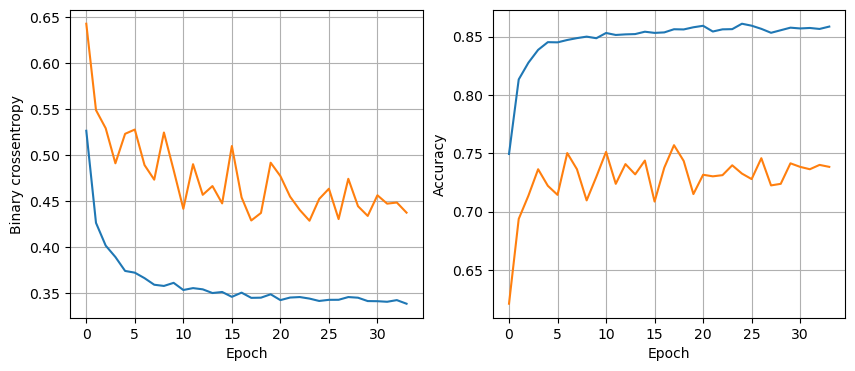



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3364 - accuracy: 0.8651
16 nodes, dropout 0.2, lr 0.001, batch size 32


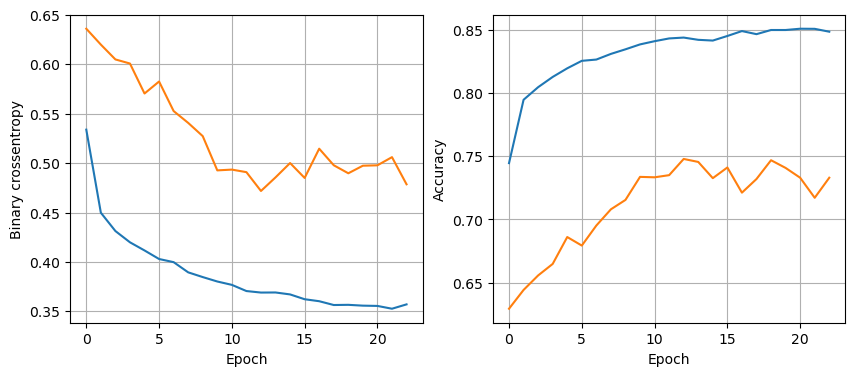



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3505 - accuracy: 0.8533
16 nodes, dropout 0.2, lr 0.001, batch size 64


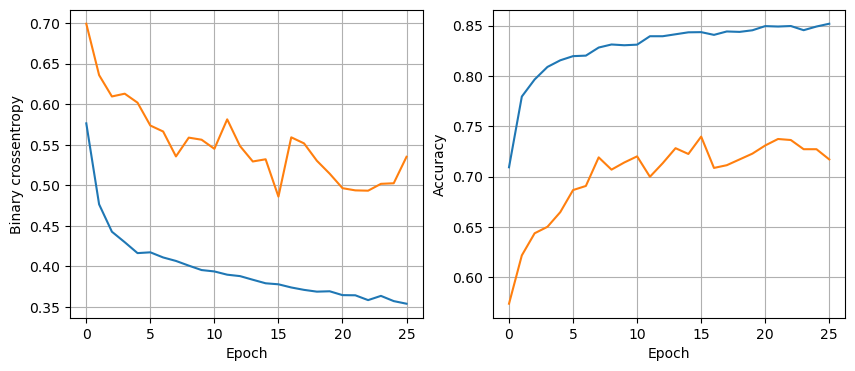



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3601 - accuracy: 0.8491
16 nodes, dropout 0.2, lr 0.001, batch size 128


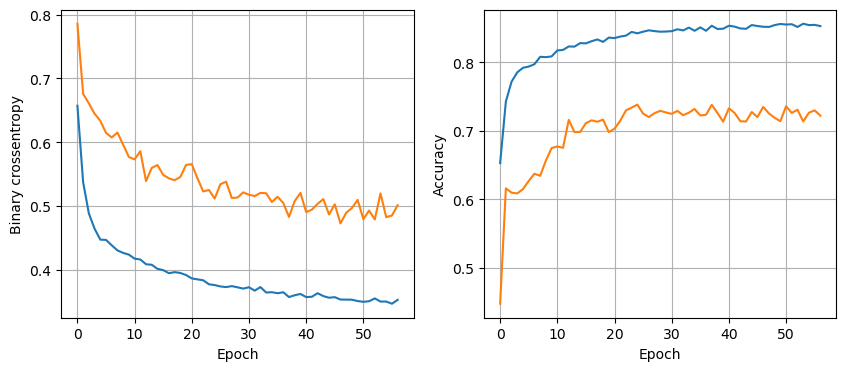



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3352 - accuracy: 0.8601
32 nodes, dropout 0, lr 0.01, batch size 32


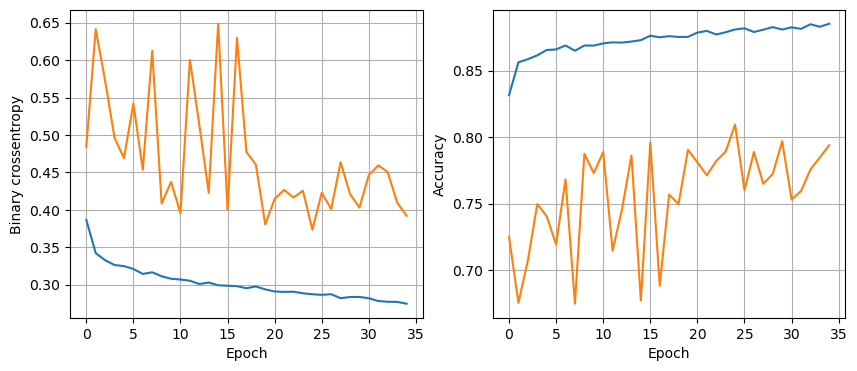



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3538 - accuracy: 0.8607
32 nodes, dropout 0, lr 0.01, batch size 64


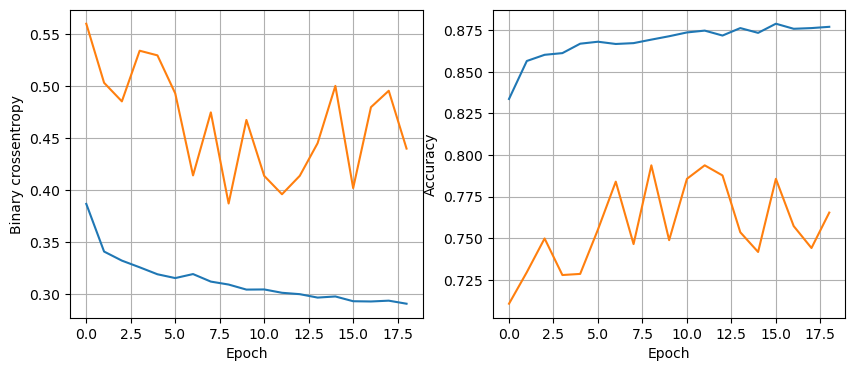



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3326 - accuracy: 0.8646
32 nodes, dropout 0, lr 0.01, batch size 128


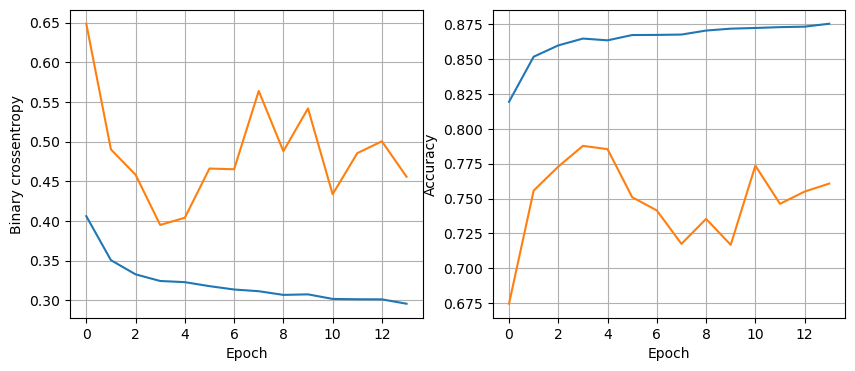



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3446 - accuracy: 0.8544
32 nodes, dropout 0, lr 0.005, batch size 32


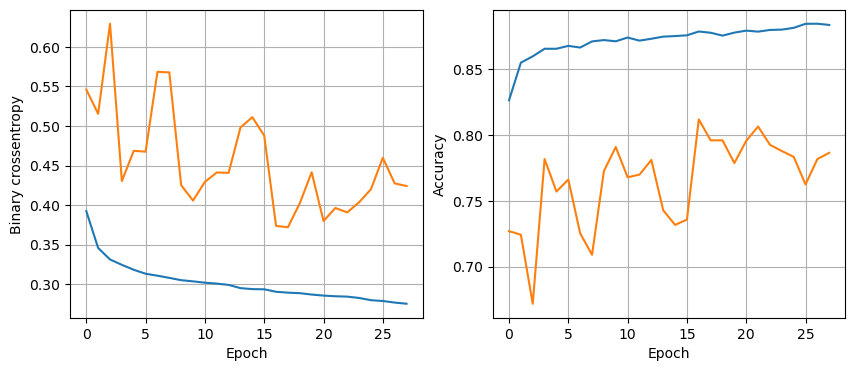



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3313 - accuracy: 0.8625
32 nodes, dropout 0, lr 0.005, batch size 64


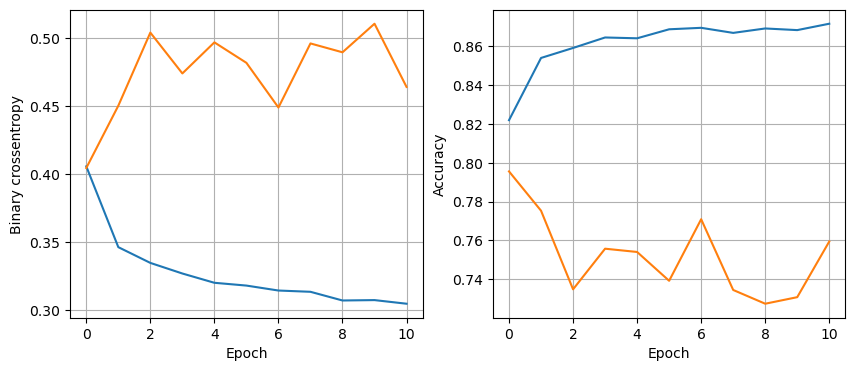



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3892 - accuracy: 0.8375
32 nodes, dropout 0, lr 0.005, batch size 128


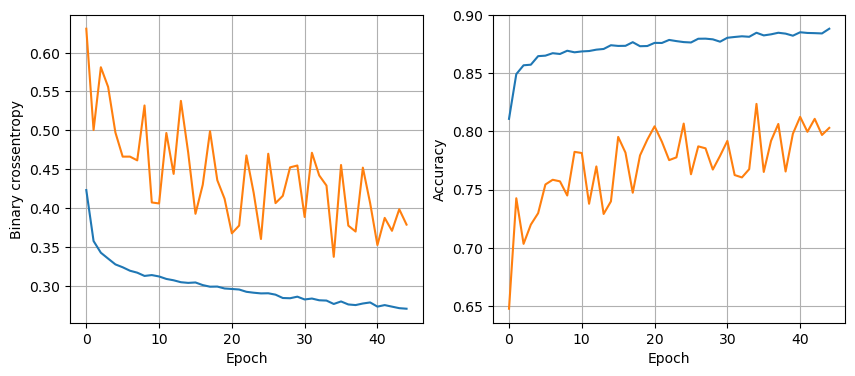



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3465 - accuracy: 0.8612
32 nodes, dropout 0, lr 0.001, batch size 32


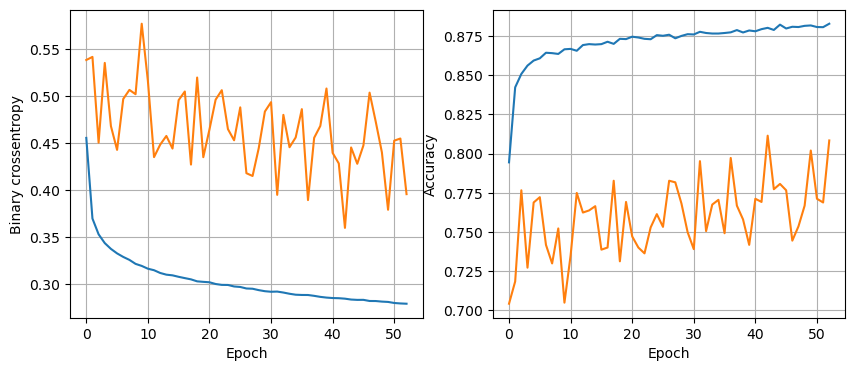



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3381 - accuracy: 0.8617
32 nodes, dropout 0, lr 0.001, batch size 64


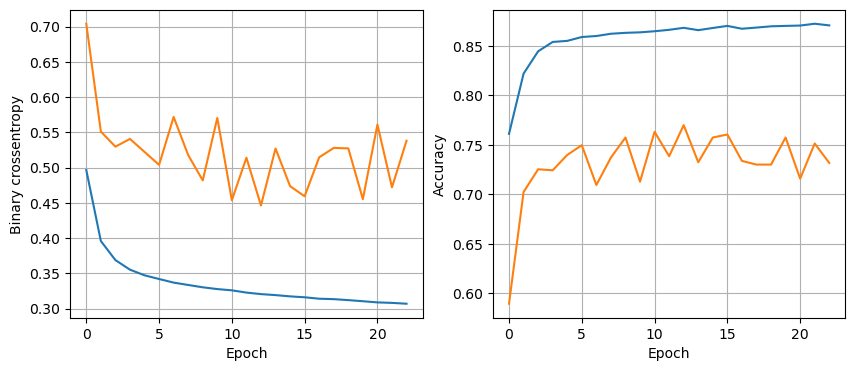



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3357 - accuracy: 0.8588
32 nodes, dropout 0, lr 0.001, batch size 128


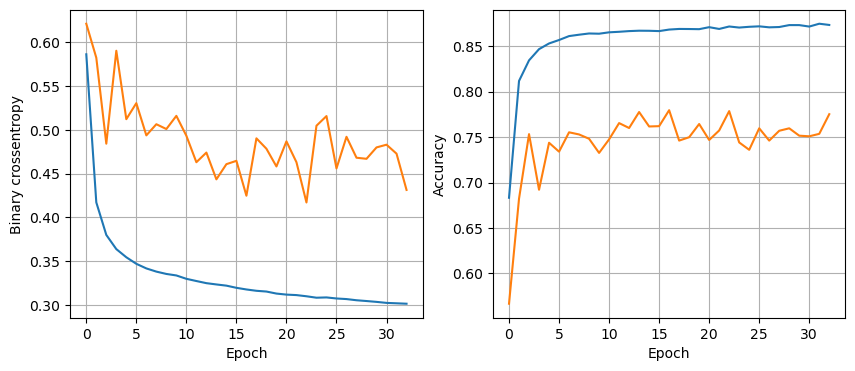



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3382 - accuracy: 0.8573
32 nodes, dropout 0.2, lr 0.01, batch size 32


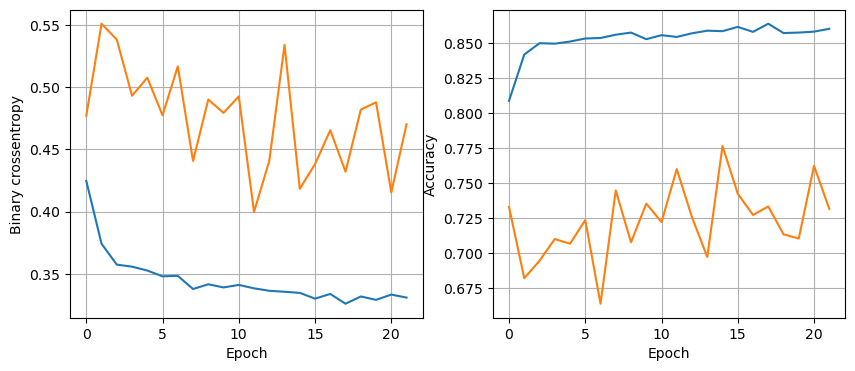



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3375 - accuracy: 0.8607
32 nodes, dropout 0.2, lr 0.01, batch size 64


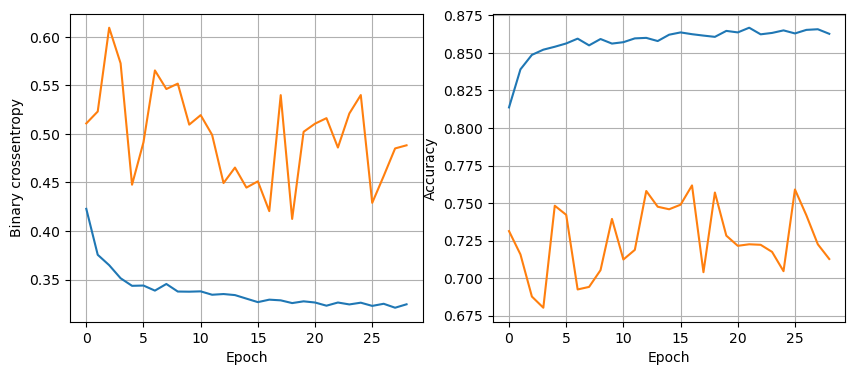



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3366 - accuracy: 0.8630
32 nodes, dropout 0.2, lr 0.01, batch size 128


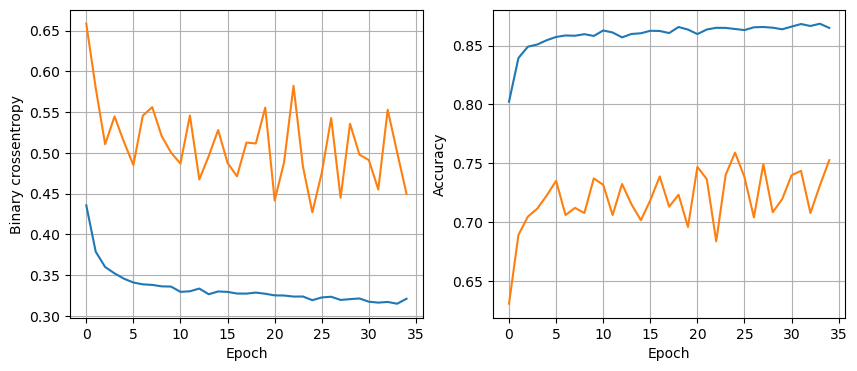



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3278 - accuracy: 0.8659
32 nodes, dropout 0.2, lr 0.005, batch size 32


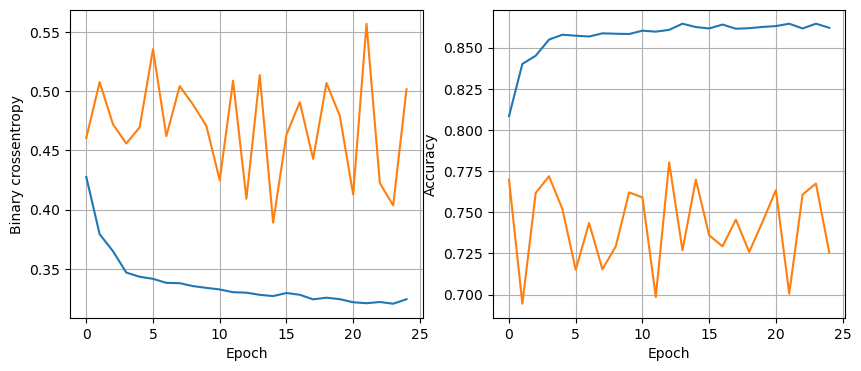



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3424 - accuracy: 0.8649
32 nodes, dropout 0.2, lr 0.005, batch size 64


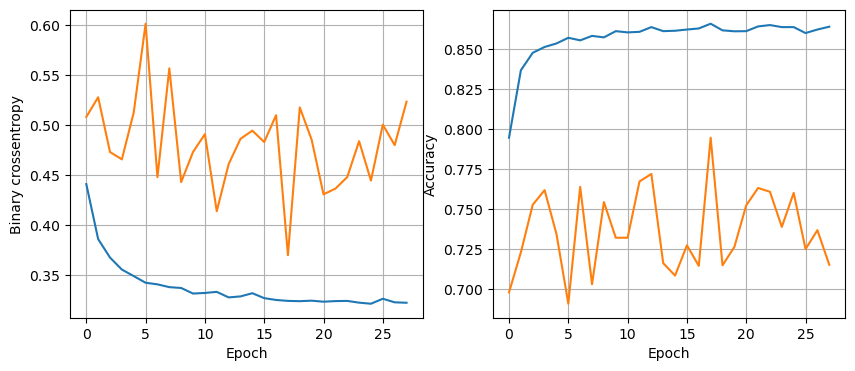



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3399 - accuracy: 0.8617
32 nodes, dropout 0.2, lr 0.005, batch size 128


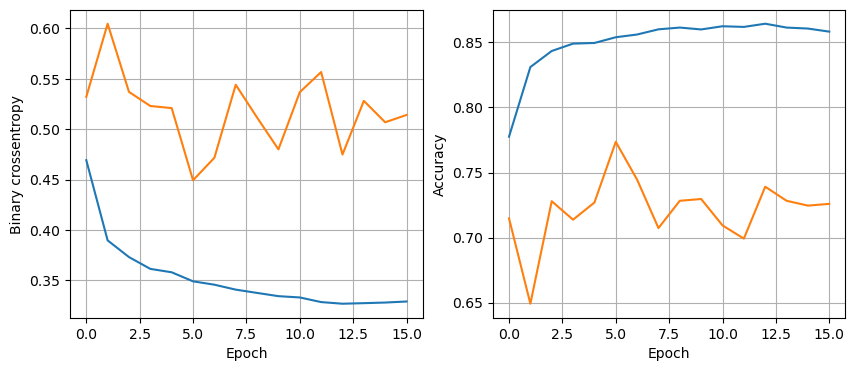



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3549 - accuracy: 0.8481
32 nodes, dropout 0.2, lr 0.001, batch size 32


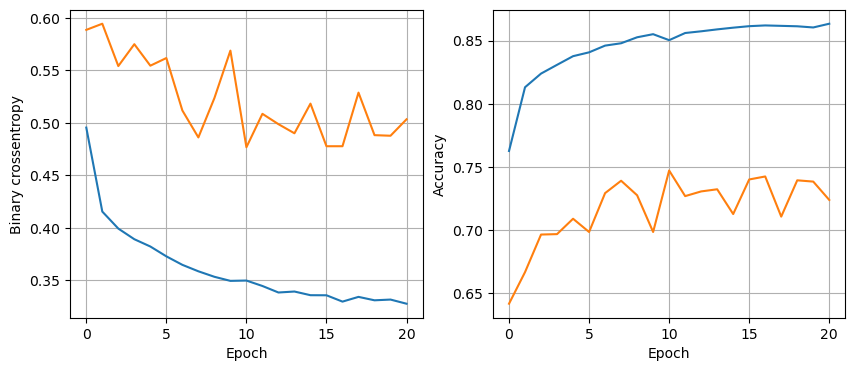



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3362 - accuracy: 0.8609
32 nodes, dropout 0.2, lr 0.001, batch size 64


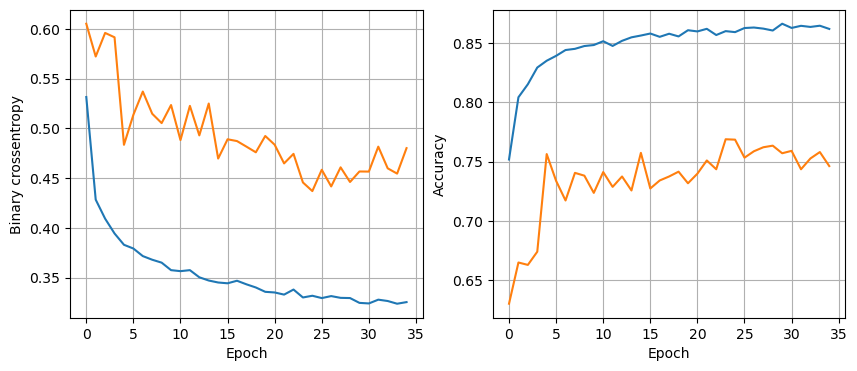



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3254 - accuracy: 0.8651
32 nodes, dropout 0.2, lr 0.001, batch size 128


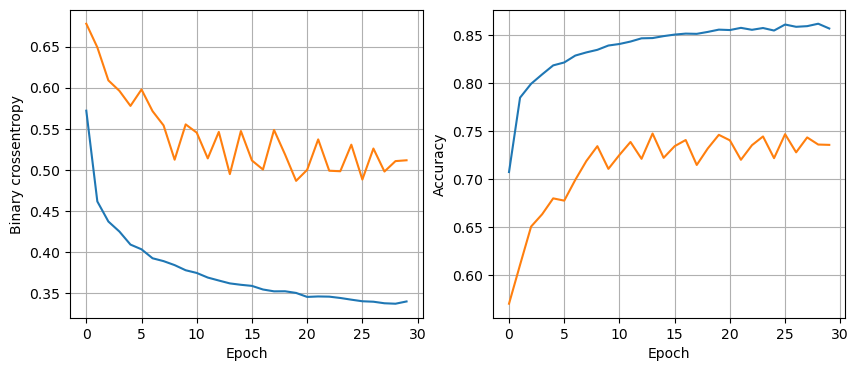



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3386 - accuracy: 0.8609
64 nodes, dropout 0, lr 0.01, batch size 32


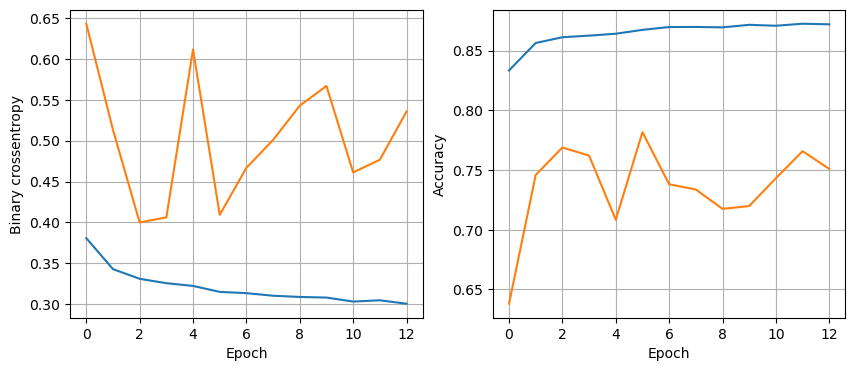



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3426 - accuracy: 0.8636
64 nodes, dropout 0, lr 0.01, batch size 64


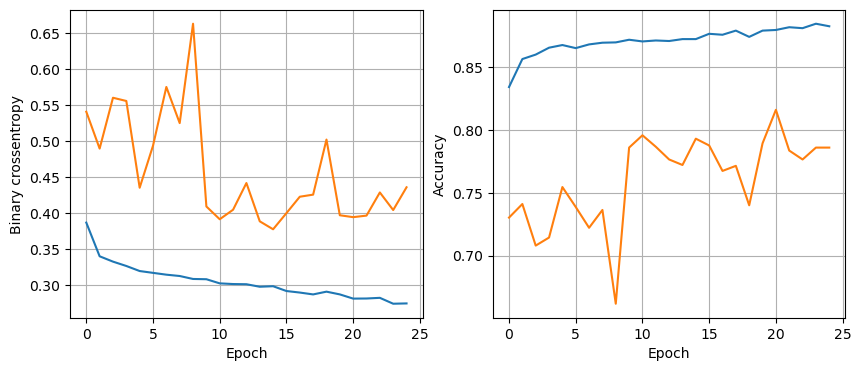



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3404 - accuracy: 0.8638
64 nodes, dropout 0, lr 0.01, batch size 128


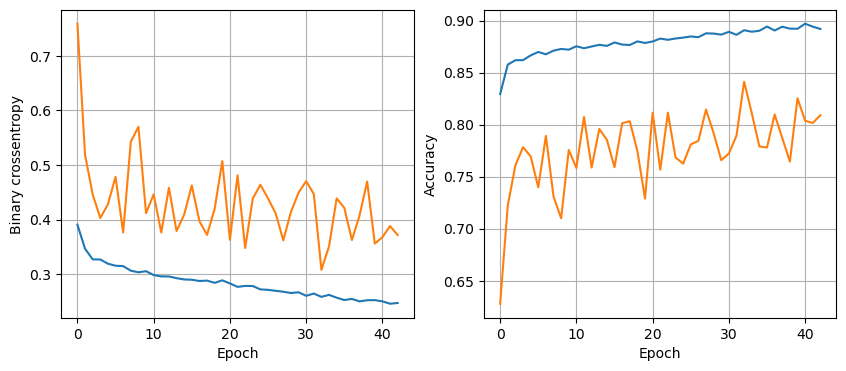



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3684 - accuracy: 0.8523
64 nodes, dropout 0, lr 0.005, batch size 32


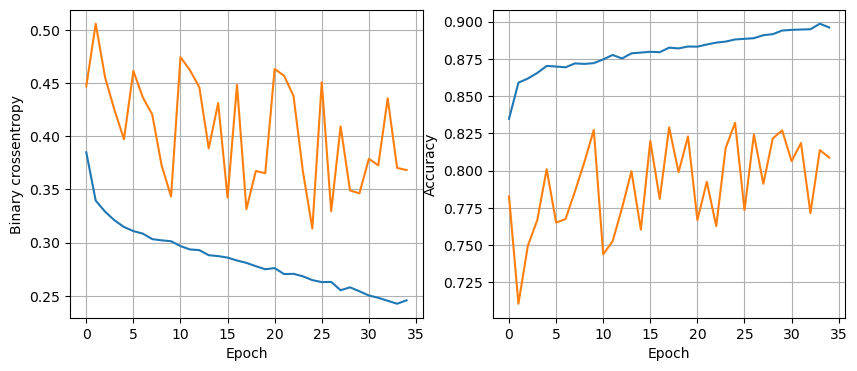



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3576 - accuracy: 0.8552
64 nodes, dropout 0, lr 0.005, batch size 64


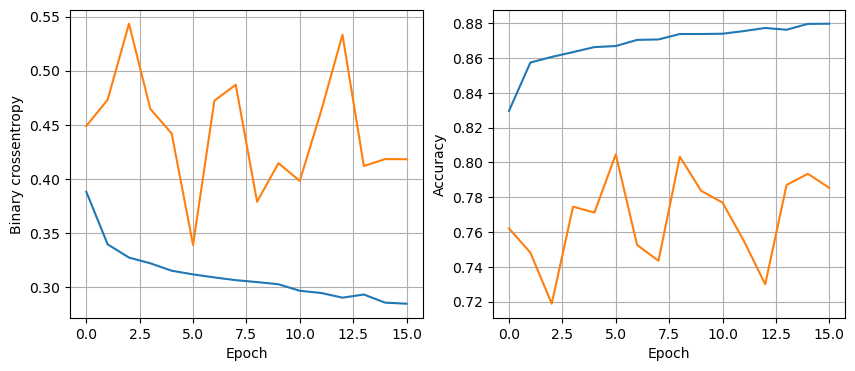



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3509 - accuracy: 0.8578
64 nodes, dropout 0, lr 0.005, batch size 128


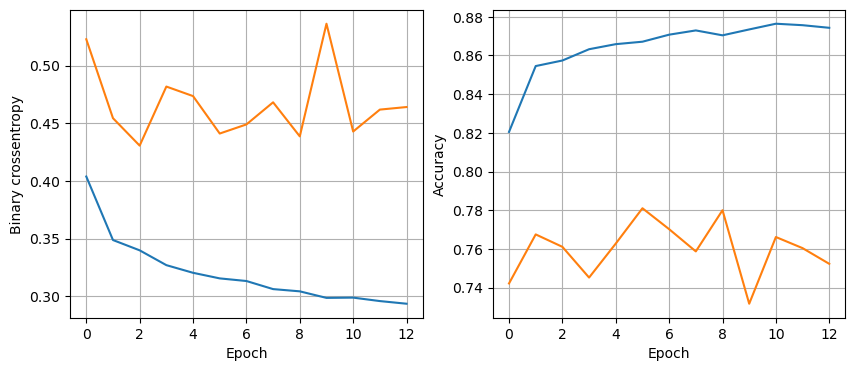



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3381 - accuracy: 0.8615
64 nodes, dropout 0, lr 0.001, batch size 32


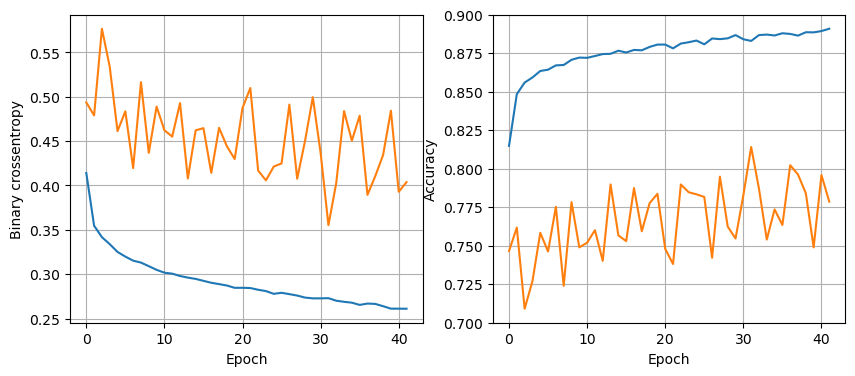



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3301 - accuracy: 0.8670
64 nodes, dropout 0, lr 0.001, batch size 64


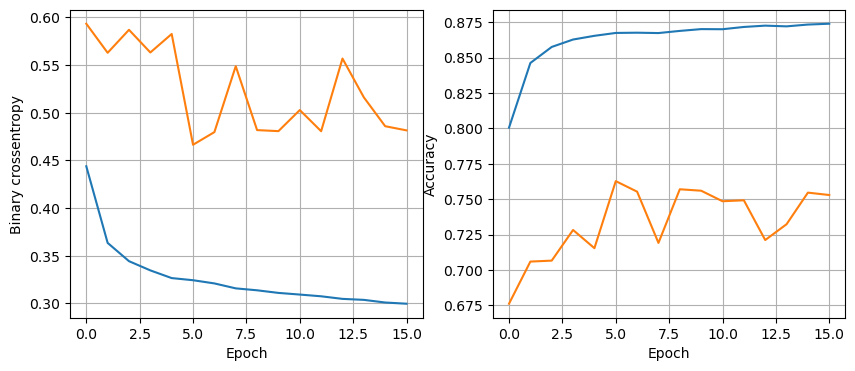



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3352 - accuracy: 0.8620
64 nodes, dropout 0, lr 0.001, batch size 128


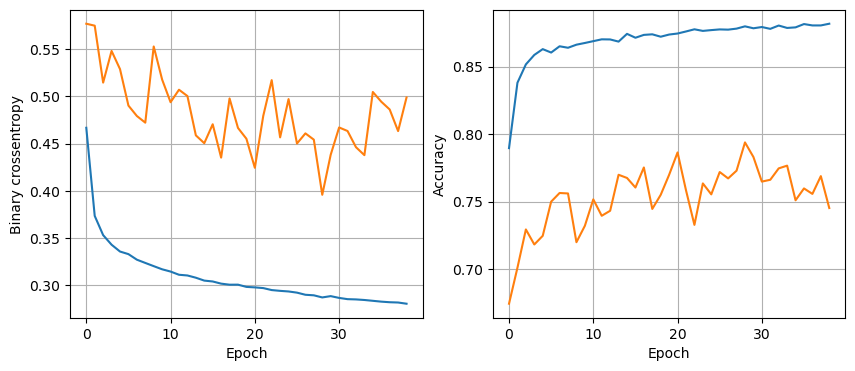



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3261 - accuracy: 0.8623
64 nodes, dropout 0.2, lr 0.01, batch size 32


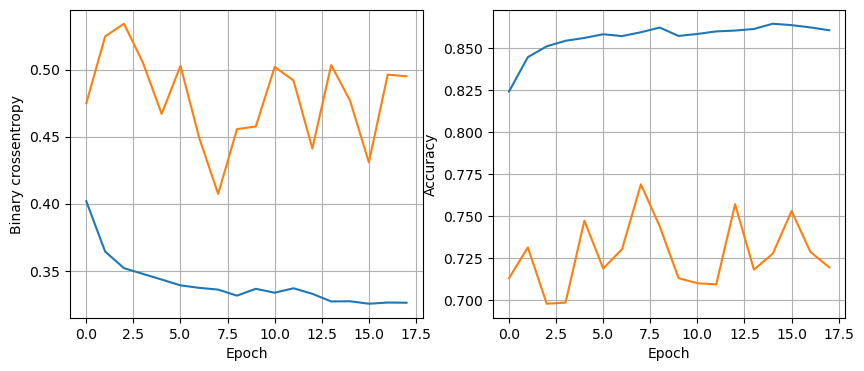



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3338 - accuracy: 0.8646
64 nodes, dropout 0.2, lr 0.01, batch size 64


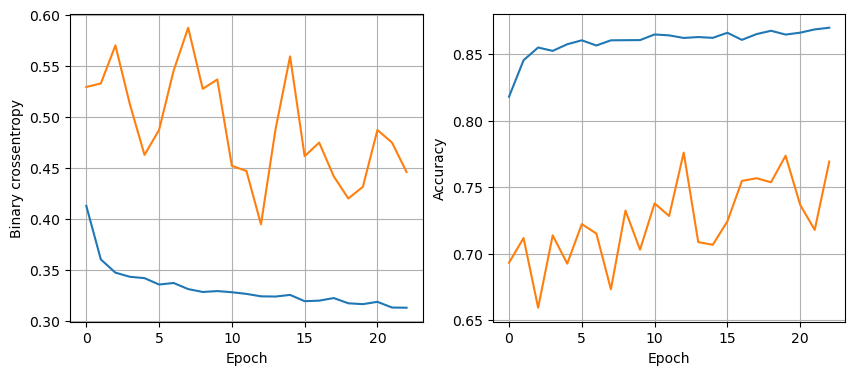



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3274 - accuracy: 0.8696
64 nodes, dropout 0.2, lr 0.01, batch size 128


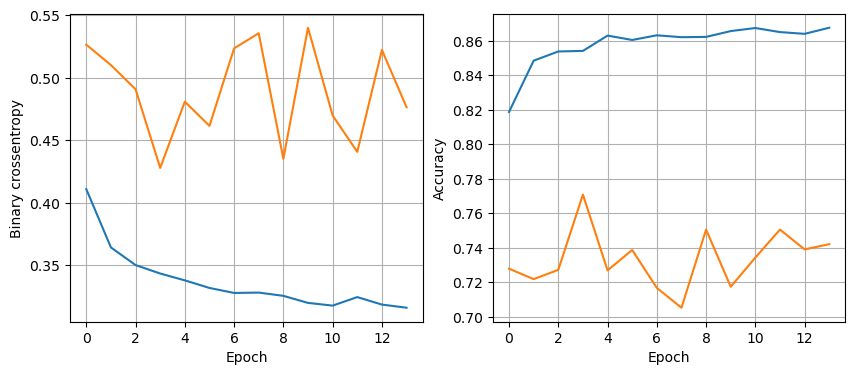



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3516 - accuracy: 0.8502
64 nodes, dropout 0.2, lr 0.005, batch size 32


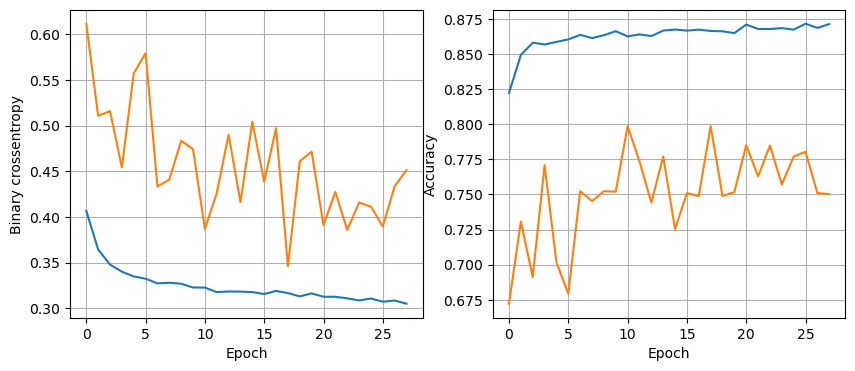



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3372 - accuracy: 0.8633
64 nodes, dropout 0.2, lr 0.005, batch size 64


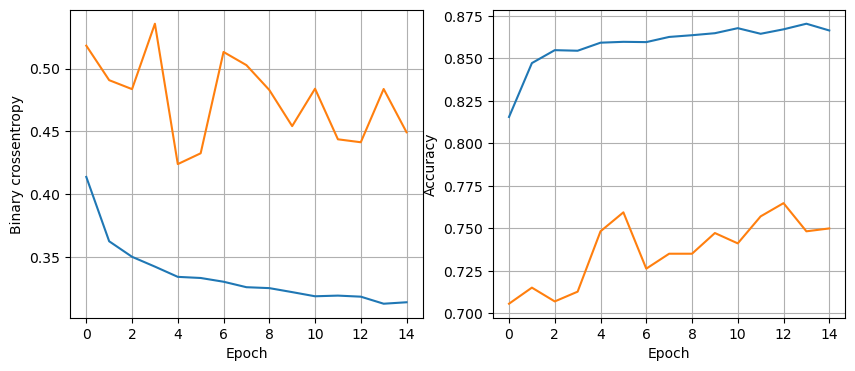



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3338 - accuracy: 0.8641
64 nodes, dropout 0.2, lr 0.005, batch size 128


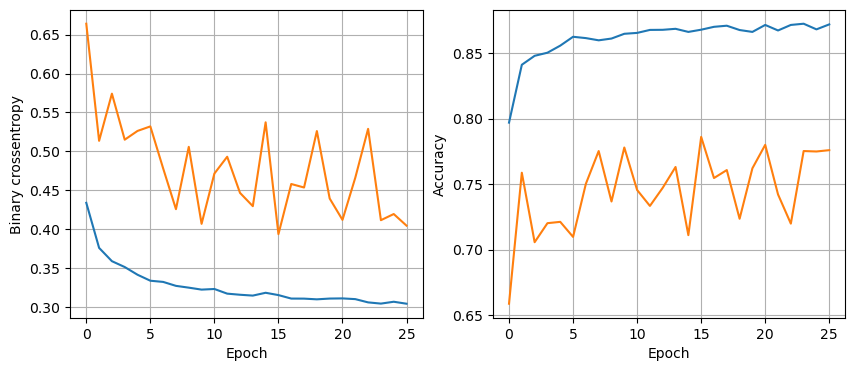



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3227 - accuracy: 0.8646
64 nodes, dropout 0.2, lr 0.001, batch size 32


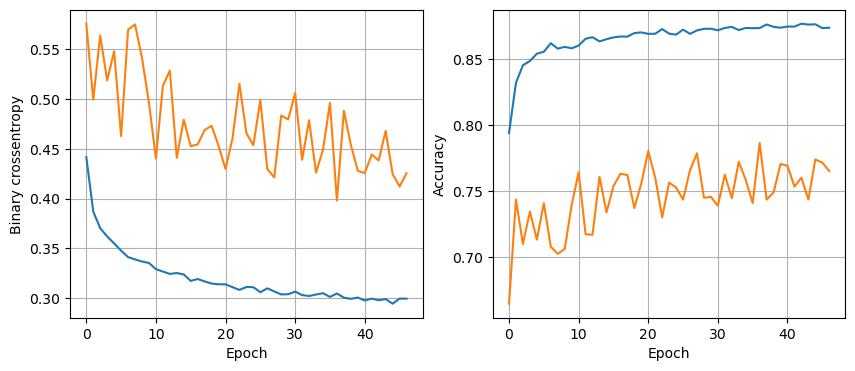



**********************************************************************************************


119/119 [==============================] - 0s 2ms/step - loss: 0.3185 - accuracy: 0.8696
64 nodes, dropout 0.2, lr 0.001, batch size 64


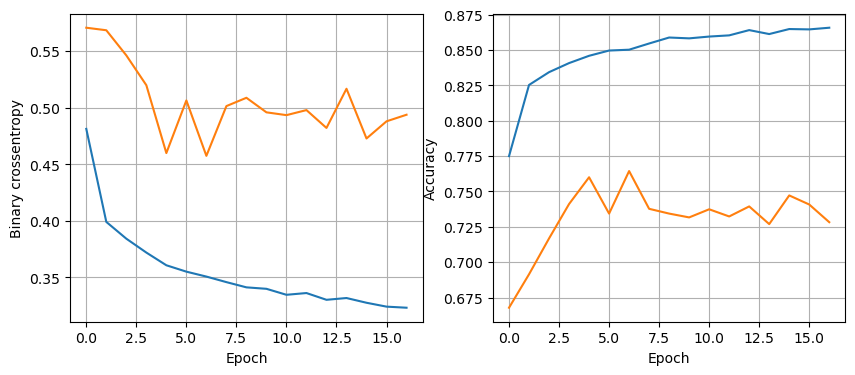



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3448 - accuracy: 0.8559
64 nodes, dropout 0.2, lr 0.001, batch size 128


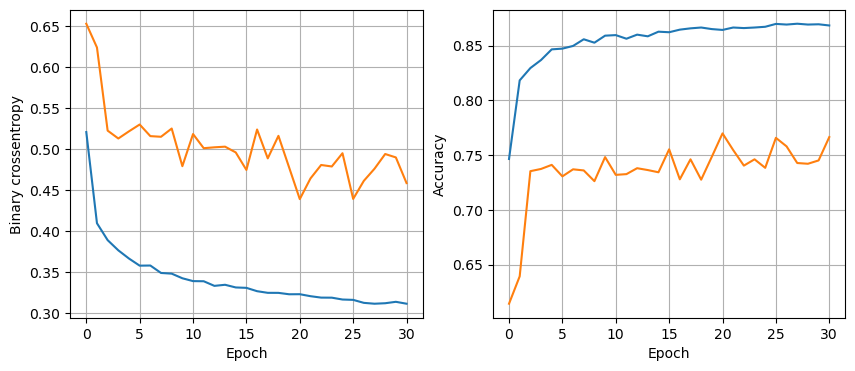



**********************************************************************************************


119/119 [==============================] - 0s 3ms/step - loss: 0.3212 - accuracy: 0.8683


In [14]:
least_val_loss = float("inf")
least_loss_model = None
epochs = 100
for num_nodes in [16, 32, 64]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.01, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                print(
                    f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}"
                )
                model, history = train_model(
                    X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs
                )
                plot_history(history)
                print("\n")# * 2)  
                print('**********************************************************************************************')
                print("\n")
                val_loss = model.evaluate(X_valid, y_valid)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model


## Prediction

In [15]:
y_pred = least_loss_model.predict(X_test)
y_pred = (
    (y_pred > 0.5)
    .astype(int)
    .reshape(
        -1,
    )
)

119/119 [==============================] - 0s 1ms/step


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1324
           1       0.89      0.90      0.90      2480

    accuracy                           0.87      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.87      0.87      0.87      3804

